# Local Surrogate Model - LIME

In [78]:
import pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lime import lime_tabular

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score

## Treina Modelo de Random Forest

In [79]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "earthquake_data_tsunami.csv"

# Load the latest version
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "ahmeduzaki/global-earthquake-tsunami-risk-assessment-dataset",
  file_path)

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   magnitude  782 non-null    float64
 1   cdi        782 non-null    int64  
 2   mmi        782 non-null    int64  
 3   sig        782 non-null    int64  
 4   nst        782 non-null    int64  
 5   dmin       782 non-null    float64
 6   gap        782 non-null    float64
 7   depth      782 non-null    float64
 8   latitude   782 non-null    float64
 9   longitude  782 non-null    float64
 10  Year       782 non-null    int64  
 11  Month      782 non-null    int64  
 12  tsunami    782 non-null    int64  
dtypes: float64(6), int64(7)
memory usage: 79.6 KB


In [81]:
df.head()

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami
0,7.0,8,7,768,117,0.509,17.0,14.000,-9.7963,159.596,2022,11,1
1,6.9,4,4,735,99,2.229,34.0,25.000,-4.9559,100.738,2022,11,0
2,7.0,3,3,755,147,3.125,18.0,579.000,-20.0508,-178.346,2022,11,1
3,7.3,5,5,833,149,1.865,21.0,37.000,-19.2918,-172.129,2022,11,1
4,6.6,0,2,670,131,4.998,27.0,624.464,-25.5948,178.278,2022,11,1


In [82]:
X = df.drop(columns=["tsunami"])
y = df["tsunami"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [83]:
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [84]:
y_pred = random_forest_model.predict(X_test)
y_pred_proba = random_forest_model.predict_proba(X_test)

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score

def show_classification_report(y_true, y_pred, target_names):
    roc_auc = roc_auc_score(y_true, y_pred_proba[:, 1])

    cm = confusion_matrix(y_true, y_pred)

    print("Classification Report:\n")
    print(f"ROC AUC Score: {roc_auc:.4f}\n")

    classification_report(y_test, y_pred, target_names=['No Tsunami', 'Tsunami'])
    print(classification_report(y_test, y_pred, target_names=['No Tsunami', 'Tsunami']))

    # Crie a visualização
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, 
        display_labels=['No Tsunami', 'Tsunami']
    )

    # Use o argumento 'cmap' para definir a nova paleta de cores
    disp.plot(cmap='Blues')

Classification Report:

ROC AUC Score: 0.9641

              precision    recall  f1-score   support

  No Tsunami       0.98      0.92      0.95        96
     Tsunami       0.88      0.97      0.92        61

    accuracy                           0.94       157
   macro avg       0.93      0.94      0.93       157
weighted avg       0.94      0.94      0.94       157



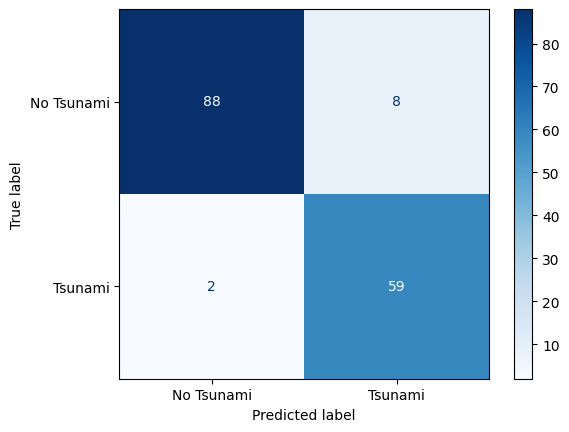

In [86]:
show_classification_report(y_test, y_pred, target_names=['No Tsunami', 'Tsunami'])

## LIME

In [ ]:
sample_id = 4  # Índice da amostra de teste a ser explicada

prediction = random_forest_model.predict(X_test.iloc[sample_id].values.reshape(1, -1))
print(f"Predicted class for sample {sample_id}: {prediction[0]}")

Predicted class for sample 4: 0


/Users/jvlm/repositories/explainable_ai/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [117]:
print(f"Predicted class for sample {sample_id}: {prediction[0]}")

Predicted class for sample 4: 0


In [ ]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['No Tsunami', 'Tsunami'],
    mode='classification'
)

exp = explainer.explain_instance(
    data_row=X_test.iloc[sample_id],
    predict_fn=random_forest_model.predict_proba)

In [ ]:

# Pega a explicação como uma lista de tuplas no formato ('feature', peso)
explanation_list = exp.as_list()
explanation_list.sort(key=lambda x: x[1], reverse=True)  # Sort by weight

# Imprime a lista para análise
print("Explicação em formato de lista:")
for feature, weight in explanation_list:
    print(f"Feature: {feature: <30} | Peso: {weight}")

Explicação em formato de lista:
Feature: -2.31 < latitude <= 24.70      | Peso: 0.02583476539029112
Feature: 754.00 < sig <= 918.00         | Peso: 0.013184630726172866
Feature: 5.00 < mmi <= 6.00             | Peso: 0.007538424691337893
Feature: magnitude > 7.10               | Peso: 0.0074996628907531655
Feature: Month > 10.00                  | Peso: -0.007737204524123299
Feature: 0.00 < cdi <= 5.00             | Peso: -0.011544260122151125
Feature: 138.00 < nst <= 445.00         | Peso: -0.03260471708155065
Feature: -71.67 < longitude <= 107.30   | Peso: -0.09139338829349891
Feature: dmin <= 0.00                   | Peso: -0.1609774986815398
Feature: Year <= 2007.00                | Peso: -0.29512173302387185


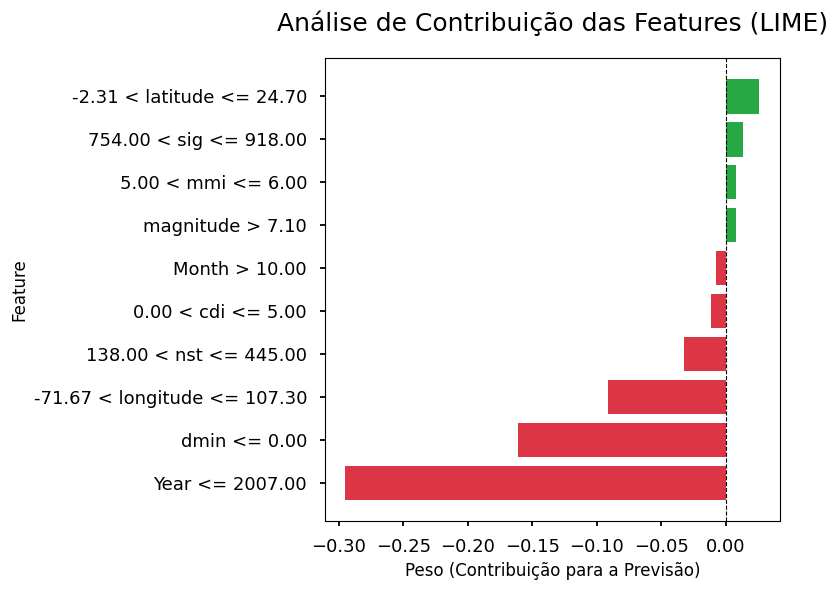

In [ ]:
features = [x[0] for x in explanation_list]
weights = [x[1] for x in explanation_list]

features.reverse()
weights.reverse()

colors = ['#28a745' if w > 0 else '#dc3545' for w in weights]

plt.style.use('seaborn-v0_8-talk') 
fig, ax = plt.subplots(figsize=(8, 6))

ax.barh(features, weights, color=colors)

ax.set_title('Análise de Contribuição das Features (LIME)', fontsize=18, pad=20)
ax.set_xlabel('Peso (Contribuição para a Previsão)', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)

ax.axvline(0, color='black', linewidth=0.8, linestyle='--')

fig.tight_layout()

plt.show()